<h1><b>QUBOs for Combinatorial Problems<b><h1>

<h2><b>Imports</b></h2>

In [11]:
import matplotlib.pyplot as plt
import networkx as nx 
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from pprint import pprint
import json

In [12]:
from openqaoa.problems import MinimumVertexCover
from openqaoa import QAOA
from openqaoa.backends import create_device

from dwave.system import DWaveSampler, EmbeddingComposite
import itertools

from numba import cuda , njit

<H3>NP HARD GRAPH PROBLEM</H3>
<P>We choose vertex cover as the selected NP graph problem</P>

<h2><b>QUBO Formulation</b></h2>

Unconstrained Formulation of Vertex Cover 

In this project, the **unconstrained formulation** was chosen because it strikes a balance between practicality and efficiency when working with cloud-based quantum systems like D-Wave. By embedding the constraints directly into the objective function as penalty terms, this approach eliminates the need for additional variables, thus reducing the complexity and resource requirements on quantum hardware.

The **QUBO formulation** used ensures that every edge in the graph is covered by at least one of its endpoints, as shown in the equation below:

$$ C = R $$

Where:

$$ \sum_{(v) \in V} X_v + P $$

$$ \sum_{(u,v) \in E} (1 - x_u - x_v + x_u x_v) $$

- **x_i = 1**, if node \(i\) is in the cover
- **x_i = 0**, otherwise

This QUBO formulation ensures that every edge in the graph is covered by at least one of its endpoints while minimizing the total number of vertices in the cover.


In [13]:
#Number of wires needs to be equal to the number of nodes in the graph for the pennylane implementation
wires = 6

#Depth of the QAOA circuit
depth = 2

In [14]:
np.random.seed(42)
example_graph= nx.generators.fast_gnp_random_graph(n=wires, p=0.6, seed=42)

In [15]:
# Function to plot the graph
def plot_graph(graph, pos=None):
    plt.figure()
    if pos is None:
        pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, font_weight="bold")
    plt.show()

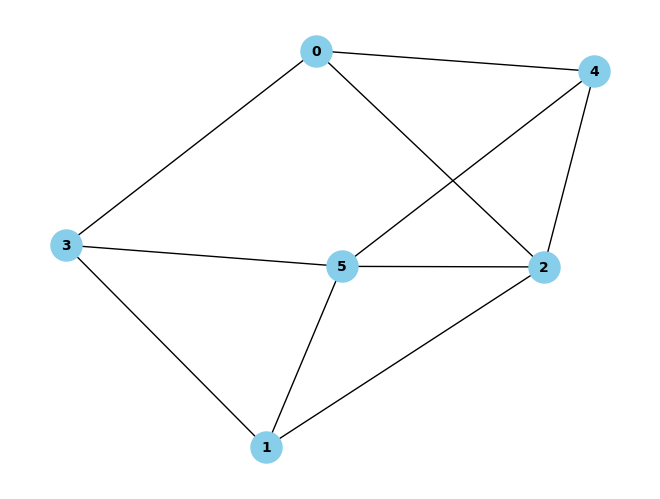

In [16]:
plot_graph(example_graph)

# QAOA Implementation 

<p>To implement the QAOA formulation we can use the pennylane Library to handle the cost Hamiltonian & the mixer Hamiltonian.</p>

<p>As stated by the documentation the Hamiltonians work in the following way</p>

The **Minimum Vertex Cover cost Hamiltonian** for constrained QAOA is defined as:

$$ H_C = - \sum_{v \in V(G)} Z_v $$

Where:

- \( V(G) \) is the set of vertices of the input graph
- \( Z_i \) is the Pauli-Z operator applied to the \(i\)-th vertex

The returned **mixer Hamiltonian** is the result of applying `bit_flip_mixer()` to the graph \(G\).

## Hamiltonians 

In [48]:
def hamiltonian_results(G):
    
    cost_h , mixer_h = qml.qaoa.min_vertex_cover(G)
    
    return cost_h , mixer_h 

In [49]:
cost_h , mixer_h = hamiltonian_results(example_graph)
print(f"Cost Hamiltonian: {cost_h}")
print(f"Mixer Hamiltonian: {mixer_h}")

Cost Hamiltonian: -1 * Z(0) + -1 * Z(1) + -1 * Z(2) + -1 * Z(3) + -1 * Z(4) + -1 * Z(5)
Mixer Hamiltonian: 0.125 * X(0) + -0.125 * (X(0) @ Z(4)) + -0.125 * (X(0) @ Z(3)) + 0.125 * (X(0) @ Z(3) @ Z(4)) + -0.125 * (X(0) @ Z(2)) + 0.125 * (X(0) @ Z(2) @ Z(4)) + 0.125 * (X(0) @ Z(2) @ Z(3)) + -0.125 * (X(0) @ Z(2) @ Z(3) @ Z(4)) + 0.125 * X(1) + -0.125 * (X(1) @ Z(5)) + -0.125 * (X(1) @ Z(3)) + 0.125 * (X(1) @ Z(3) @ Z(5)) + -0.125 * (X(1) @ Z(2)) + 0.125 * (X(1) @ Z(2) @ Z(5)) + 0.125 * (X(1) @ Z(2) @ Z(3)) + -0.125 * (X(1) @ Z(2) @ Z(3) @ Z(5)) + 0.0625 * X(2) + -0.0625 * (X(2) @ Z(5)) + -0.0625 * (X(2) @ Z(4)) + 0.0625 * (X(2) @ Z(4) @ Z(5)) + -0.0625 * (X(2) @ Z(1)) + 0.0625 * (X(2) @ Z(1) @ Z(5)) + 0.0625 * (X(2) @ Z(1) @ Z(4)) + -0.0625 * (X(2) @ Z(1) @ Z(4) @ Z(5)) + -0.0625 * (X(2) @ Z(0)) + 0.0625 * (X(2) @ Z(0) @ Z(5)) + 0.0625 * (X(2) @ Z(0) @ Z(4)) + -0.0625 * (X(2) @ Z(0) @ Z(4) @ Z(5)) + 0.0625 * (X(2) @ Z(0) @ Z(1)) + -0.0625 * (X(2) @ Z(0) @ Z(1) @ Z(5)) + -0.0625 * (X(2) @

<p>Now that we have the Hamiltonians we need to constract the layers of our circuit and we need to have the cost & mixer layers to be alternated applied to our QAOA circuit continuously</p>

## Layer Implementation

In [50]:
### QAOA Circuit Implementation

# The cost_and_mixer_layers function is used to apply the cost and mixer Hamiltonians to the qubits.
def cost_and_mixer_layers(gamma, alpha):
    qml.qaoa.cost_layer(gamma, cost_h)
    qml.qaoa.mixer_layer(alpha, mixer_h)

#ApproxTimeEvolution template is used to approximate the time evolution operator e^(-i*H*t) for a given Hamiltonian H.
def circuit(params):
    for w in range(wires):
        qml.Hadamard(wires=w)
    qml.layer(cost_and_mixer_layers, depth, params[0], params[1])

Since we want to try multiple optimization methods, we'll try to implement another minimun vertex cover model from the library OPENQAOA.  
It's possible to do so due to the coodipendencies of these two libraries. As such, the qubo formulation and the hamiltonians are the same.


In [17]:
### OPENQAOA Implementation
mvc_prob = MinimumVertexCover(example_graph, field=1.0, penalty=10)
mvc_qubo = mvc_prob.qubo


In [18]:
pprint(mvc_qubo.asdict())

{'constant': 28.0,
 'metadata': {},
 'n': 6,
 'problem_instance': {'G': {'directed': False,
                            'graph': {},
                            'links': [{'source': 0, 'target': 2},
                                      {'source': 0, 'target': 3},
                                      {'source': 0, 'target': 4},
                                      {'source': 1, 'target': 2},
                                      {'source': 1, 'target': 3},
                                      {'source': 1, 'target': 5},
                                      {'source': 2, 'target': 4},
                                      {'source': 2, 'target': 5},
                                      {'source': 3, 'target': 5},
                                      {'source': 4, 'target': 5}],
                            'multigraph': False,
                            'nodes': [{'id': 0},
                                      {'id': 1},
                                      {'id': 2},
          

### OPENQAOA Model creation function

What then changes is the way the model is implemented in its OPENQOAOA custom structure.  
In particular, the cost function is expressed as following:

The corresponding function to minimize can be derived as:

$$ C = \sum_{v \in V} x_v + \lambda \sum_{(u,v) \in E} (1 - x_u - x_v + x_u x_v) $$

Where:
- \( x_v = 1 \) if vertex \(v\) is part of the vertex cover, and 0 otherwise
- Lambda is the penalty, a parameter controlling the strength of penalization for configurations that are not valid covers

As for the interpretation:
- The first summation counts the size of the selected cover.
- The second summation ensures that all edges in the graph are covered by at least one of their endpoints.

Minimizing this function ensures we find the **minimum vertex cover**.  
Note that this cost function can be conveniently converted to the form of an **Ising problem** to be used with QAOA.


In [24]:
def open_qoaoa_model(mvc_qubo, depth=2):
    # initialize model with default configurations
    q = QAOA()

    # optionally configure the following properties of the model
    
    
    # TODO: try adding the mixer hamiltonian from the QAOA implementation, maybe change qiskit to aer
    # circuit properties
    q.set_circuit_properties(p=depth, param_type='standard', init_type='rand', mixer_hamiltonian='x')

    # device
    qiskit_device = create_device(location='local', name='qiskit.qasm_simulator')
    q.set_device(qiskit_device)

    # classical optimizer properties

    q.set_classical_optimizer(method='cobyla', maxiter=200, tol=0.001,
                        optimization_progress=True, cost_progress=True, parameter_log=True)

    #Compile the QUBO into the QAOA model
    q.compile(mvc_qubo)
    
    return q


## Parameters Optimization

We will now explore two methods of optimization, which are going to be explored and compared, to then ultimately land on a single method which will be used for the rest of the project.

### Gradient-free optimizer (OPENQAOA-COBYLA)

The COBYLA optimizer is a gradient-free method that uses linear approximations to optimize functions. It's effective for problems with noisy, non-differentiable, or unavailable gradients and works well with constrained optimization. However, it can be less efficient than gradient-based methods when gradients are available

We create the model for the OPENQAOA optimizer

In [25]:
q_coby = open_qoaoa_model(mvc_qubo, depth=depth)

We optimize it

In [26]:
q_coby.optimize()
q_coby.result.optimized['cost']

11.65

We plot the results of the optimization

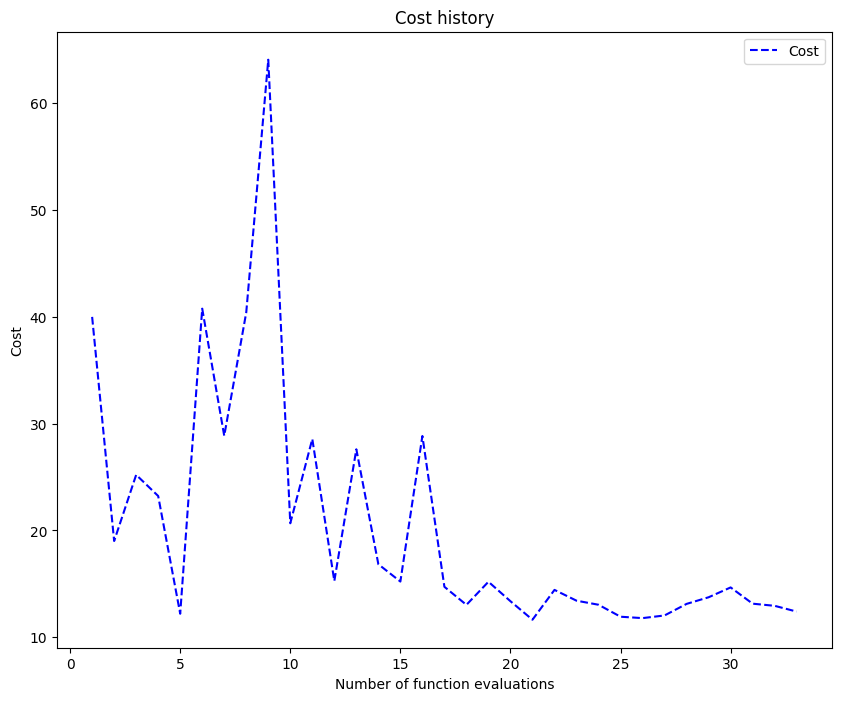

In [27]:
q_coby.result.plot_cost()
plt.show()

### Simultaneous perturbation stochastic approximation optimizer (SPSA) 

The SPSA optimizer is a gradient-dependent method that estimates gradients using random perturbations to all parameters. It is efficient for high-dimensional problems, avoiding the need to compute the full gradient, which can be costly. While it uses fewer evaluations than full-gradient methods, the accuracy depends on the size of the perturbations and the function's behavior. SPSA is commonly used in fields like machine learning and quantum computing for complex optimization tasks.

We then create the function to run the SPSA optimizer

In [28]:
#Function to run the optimizer and monitor the optimization process imported from the pennylane library
def run_optimizer(opt, cost_function, init_param, num_steps, interval, execs_per_step):
    # Copy the initial parameters to make sure they are never overwritten
    param = init_param.copy()

    # Obtain the device used in the cost function
    dev = cost_function.device

    # Initialize the memory for cost values during the optimization
    cost_history = []
    # Monitor the initial cost value
    cost_history.append(cost_function(param))
    exec_history = [0]

    print(
        f"\nRunning the {opt.__class__.__name__} optimizer for {num_steps} iterations."
    )
    for step in range(num_steps):
        # Print out the status of the optimization
        if step % interval == 0:
            print(
                f"Step {step:3d}: Circuit executions: {exec_history[step]:4d}, "
                f"Cost = {cost_history[step]}"
            )

        # Perform an update step
        param = opt.step(cost_function, param)

        # Monitor the cost value
        cost_history.append(cost_function(param))
        exec_history.append((step + 1) * execs_per_step)

    print(
        f"Step {num_steps:3d}: Circuit executions: {exec_history[-1]:4d}, "
        f"Cost = {cost_history[-1]}"
    )
    return param, cost_history, exec_history

Create the device to simulate the example graph

In [53]:
device = qml.device("qiskit.aer", wires=wires, shots=1000)

Create the cost function for the optimizer

In [54]:
@qml.qnode(device)
def cost_function(params):
    circuit(params)
    return qml.expval(cost_h)

Run the optimizer

In [56]:
np.random.seed(42)

init_param = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad=True)

num_steps_spsa = 200
opt = qml.SPSAOptimizer(maxiter=num_steps_spsa, c=0.15, a=0.2)
# We spend 2 circuit evaluations per step:
execs_per_step = 2


optmized_param ,cost_history_spsa, exec_history_spsa = run_optimizer(
    opt, cost_function, init_param, num_steps_spsa, 20, execs_per_step
)


Running the SPSAOptimizer optimizer for 200 iterations.
Step   0: Circuit executions:    0, Cost = 0.468
Step  20: Circuit executions:   40, Cost = -0.21600000000000003
Step  40: Circuit executions:   80, Cost = -0.21400000000000005
Step  60: Circuit executions:  120, Cost = -0.344
Step  80: Circuit executions:  160, Cost = -0.26
Step 100: Circuit executions:  200, Cost = -0.32
Step 120: Circuit executions:  240, Cost = -0.354
Step 140: Circuit executions:  280, Cost = -0.274
Step 160: Circuit executions:  320, Cost = -0.47400000000000003
Step 180: Circuit executions:  360, Cost = -0.25600000000000006
Step 200: Circuit executions:  400, Cost = -0.362


We show the results of the optimization over the cost function

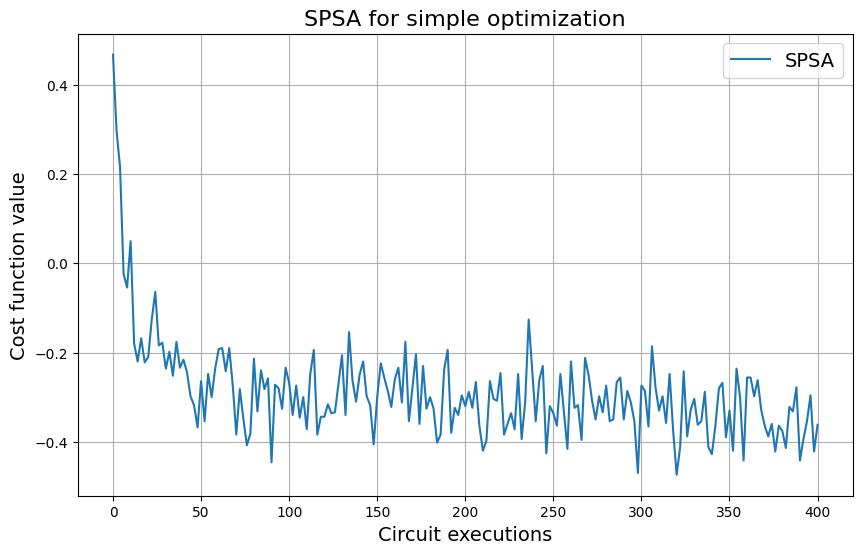

In [57]:
plt.figure(figsize=(10, 6))

plt.plot(exec_history_spsa, cost_history_spsa, label="SPSA")

plt.xlabel("Circuit executions", fontsize=14)
plt.ylabel("Cost function value", fontsize=14)
plt.grid()

plt.title("SPSA for simple optimization", fontsize=16)
plt.legend(fontsize=14)
plt.show()

### OPENQAOA Results

We can check both the string result and the graph visualization

In [29]:
#Get the optimal results from the QAOA model
optimal_results = q_coby.result.most_probable_states
print(optimal_results)

{'solutions_bitstrings': ['011110'], 'bitstring_energy': 4.0}


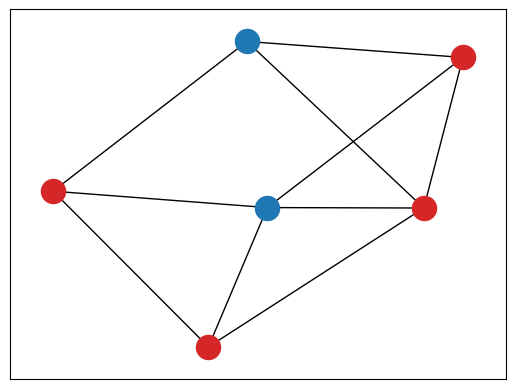

In [31]:
configuration = q_coby.result.most_probable_states['solutions_bitstrings']
np.random.seed(42)
# Plotting the OpeanQAOA results
g_sol = np.copy(example_graph)
pos =  nx.spring_layout(example_graph)
nx.draw_networkx_nodes(example_graph, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(example_graph, pos, nodelist=[idx for idx,bit in enumerate(configuration[0]) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(example_graph, pos)
plt.show()

### Pennylane SPSA Results

We repeat the same process for the SPSA, checking also the circuit results

In [58]:
#Create the optimized circuit
@qml.qnode(device)
def spsa_optimized_circuit(gamma, alpha):
    circuit([gamma, alpha])
    return qml.probs(wires=range(wires))


probs = spsa_optimized_circuit(optmized_param[0], optmized_param[1])
print(probs)

[0.013 0.011 0.018 0.014 0.013 0.017 0.01  0.015 0.016 0.014 0.019 0.019
 0.012 0.027 0.03  0.138 0.015 0.016 0.016 0.018 0.013 0.019 0.023 0.017
 0.005 0.016 0.019 0.01  0.015 0.002 0.033 0.004 0.014 0.017 0.018 0.014
 0.017 0.015 0.014 0.012 0.014 0.032 0.018 0.001 0.018 0.02  0.004 0.
 0.012 0.028 0.018 0.006 0.018 0.005 0.015 0.    0.015 0.    0.017 0.
 0.008 0.001 0.001 0.001]


In [59]:
#Take the highest probability state as the solution
solution = np.argmax(probs)
solution = np.binary_repr(solution, width=wires)
print(solution)

001111


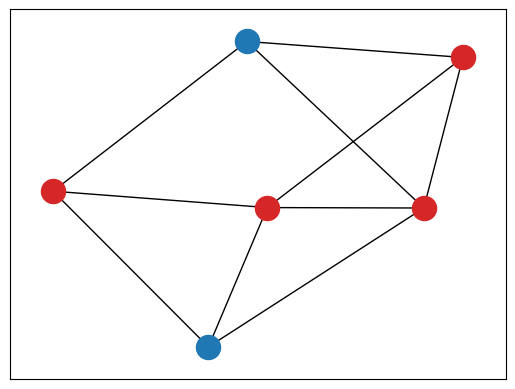

In [60]:
# Plotting the Pennylane results
np.random.seed(42)
g_sol = np.copy(example_graph)
pos =  nx.spring_layout(example_graph)
nx.draw_networkx_nodes(example_graph, pos, nodelist=[idx for idx,bit in enumerate(solution) if bit == '1'], node_color="tab:red")
nx.draw_networkx_nodes(example_graph, pos, nodelist=[idx for idx,bit in enumerate(solution) if bit == '0'], node_color="tab:blue")
nx.draw_networkx_edges(example_graph, pos)
plt.show()

Due to performance and scalability, we ultimately decided to fully implement the Pennylane SPSA optimization method

<h2><b>Cloud QAOA Implementation</b></h2>

We then solve our optimized method through cloud implementation

In [ ]:
def min_vertex_cover_qubo(graph):
    Q = {}
    penalty = len(graph.edges)  # A large constant to enforce constraints

    # Objective: Minimize the number of selected vertices
    for i in graph.nodes:
        Q[(i, i)] = 1

    # Constraint: At least one vertex of every edge is selected
    for u, v in graph.edges():
        Q[(u, v)] = Q.get((u, v), 0) + penalty
        Q[(u, u)] = Q.get((u, u), 0) - penalty
        Q[(v, v)] = Q.get((v, v), 0) - penalty

    return Q



def solve_vertex_cover_nonibm(qubo):
    sampler = EmbeddingComposite(DWaveSampler(token='Personal_Token', solver='Advantage_system4.1'))
    sampleset = sampler.sample_qubo(qubo, num_reads=1000)
    return sampleset

def extract_vertex(sampleset,graph):
    best_solution = sampleset.first.sample
    vertex_cover =  [node for node,value in best_solution.items() if value == 1]
    return vertex_cover

We solve the example to check the solution

{(0, 0): -29,
 (0, 2): 10,
 (0, 3): 10,
 (0, 4): 10,
 (1, 1): -29,
 (1, 2): 10,
 (1, 3): 10,
 (1, 5): 10,
 (2, 2): -39,
 (2, 4): 10,
 (2, 5): 10,
 (3, 3): -29,
 (3, 5): 10,
 (4, 4): -29,
 (4, 5): 10,
 (5, 5): -39}
Vertex Cover: [2, 3, 4, 5]


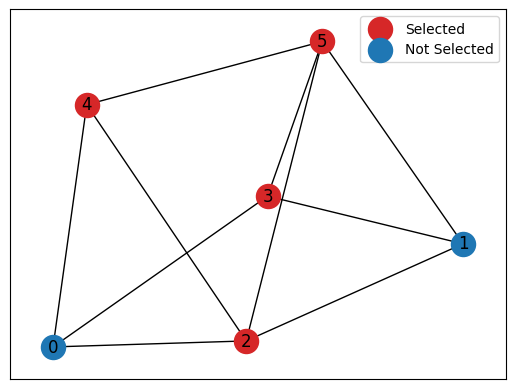

In [ ]:
qubo =  min_vertex_cover_qubo(example_graph)
pprint(qubo)
response = solve_vertex_cover_nonibm(qubo)
vertex_cover = extract_vertex(response, example_graph)
print(f"Vertex Cover: {vertex_cover}")

    # Plot the solution
pos = nx.spring_layout(example_graph)
nx.draw_networkx_nodes(example_graph, pos, nodelist=vertex_cover, node_color="tab:red", label="Selected")
nx.draw_networkx_nodes(example_graph, pos, nodelist=[node for node in example_graph.nodes if node not in vertex_cover], node_color="tab:blue", label="Not Selected")
nx.draw_networkx_edges(example_graph, pos)
nx.draw_networkx_labels(example_graph, pos)
plt.legend()
plt.show()


<h2><b>Brute-force Implementation</b></h2>

We then implement the bruteforce method for the MinVertexCover

In [ ]:
def is_valid_vertex_cover(G,vertex_cover) -> bool:
  #check if a certain subset is valid vertex cover for graph
  for u,v in G.edges():
    if u not in vertex_cover and v not in vertex_cover:
      return False
  return True

def brute_force_vertex_cover(G) -> set:
  n = len(G.nodes())
  nodes = list(G.nodes())
  for size in range(1,n+1):
    for vertex_cover in itertools.combinations(nodes,size):
      if is_valid_vertex_cover(G,vertex_cover):
        return set(vertex_cover) #minimum size
  return None #empty set if nothing is found

In [ ]:
brute_force_vertex_cover(example_graph)

<h2><b>Performance Evaluation</b></h2>

Since in the previous sections we created the baseline using an example graph, we can now check our methods given a set of 10 graphs with 50 nodes each

### Dataset Creation

In [ ]:
#inserts the nodes and it's connections inside the dict
def generate_graph(G) -> dict:
  # takes the number of nodes in each graph and creates a dictonary for the graph
  n = len(G.nodes())
  graph_dict = dict()

  #inside the dictionary we create an adjacency list for the graph
  for edge in G.edges:
    #if they edges don't exist as keys we make them keys with a list element
    #to put inside the connections
    if edge[0] not in graph_dict.keys():
      graph_dict[edge[0]] = list()
    if edge[1] not in graph_dict.keys():
      graph_dict[edge[1]] = list()
    graph_dict[edge[0]].append(edge[1])
    graph_dict[edge[1]].append(edge[0])
  #return the dictionary graph
  return graph_dict


"""creats a dictionary of dictionaries that contain  each graph
   with 50 vertices and it's connections"""
def create_dataset_graph() -> dict:
  """inside of the dictionary we wil have
     10 different graphs that contain 50 nodes"""
  graphs_dict = dict()
  for i in range(1,11):
      G = nx.erdos_renyi_graph(50, 0.5)
      graphs_dict[i] = generate_graph(G)
      #Not mandatory but we plot each graph
      nx.draw(G,with_labels = True, font_weight='bold',node_color="skyblue")
      plt.show()

  #return the dictionary that contains all of the graphsdis
  return graphs_dict



We visualize the created graphs

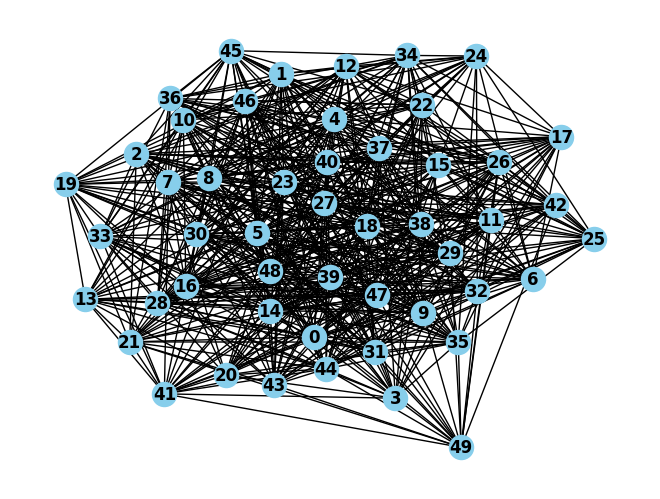

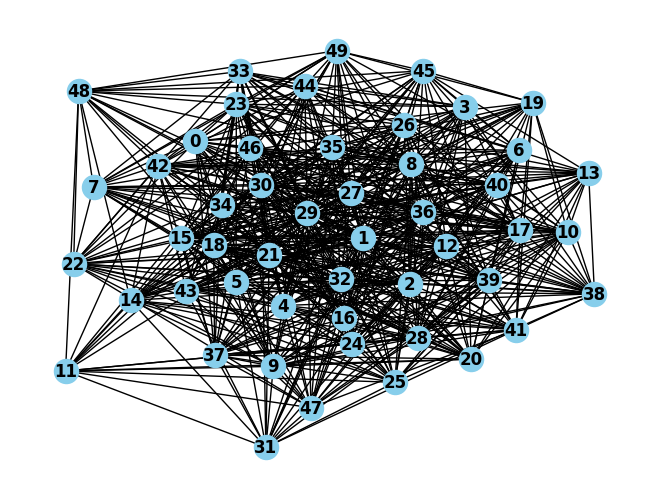

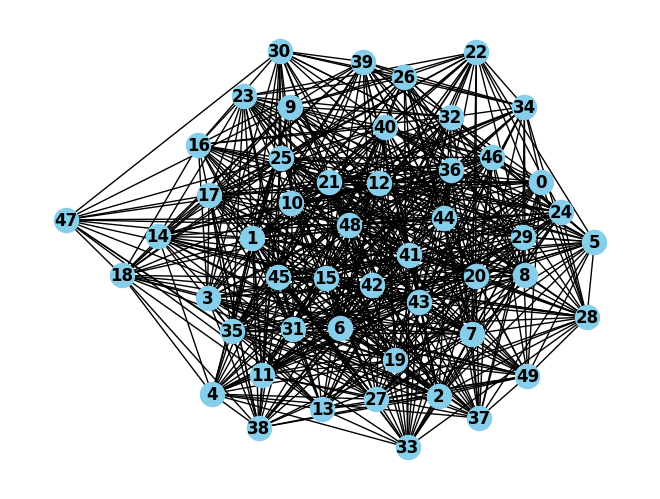

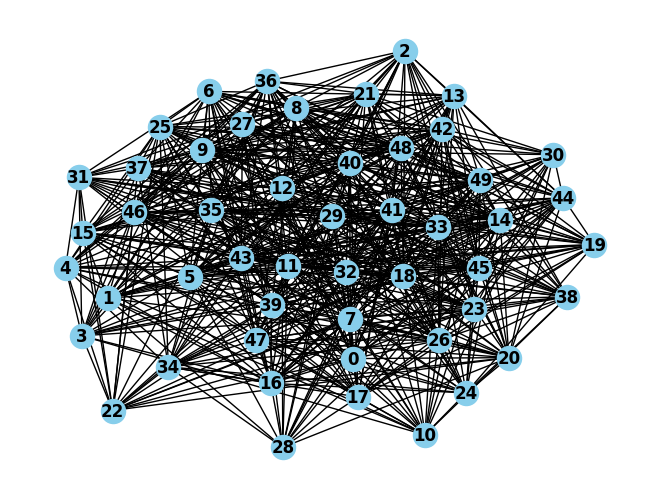

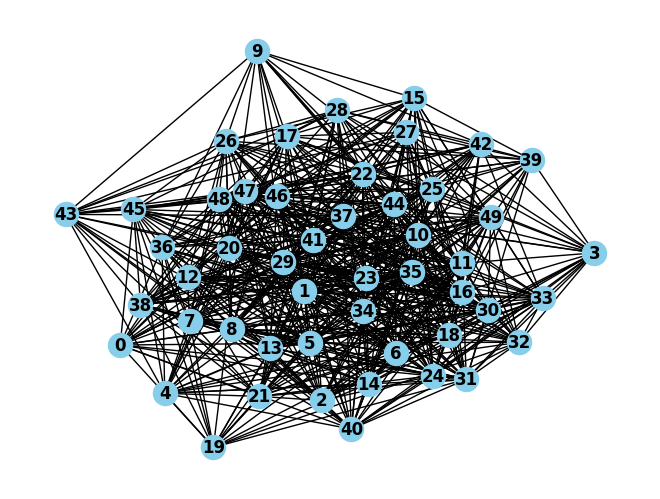

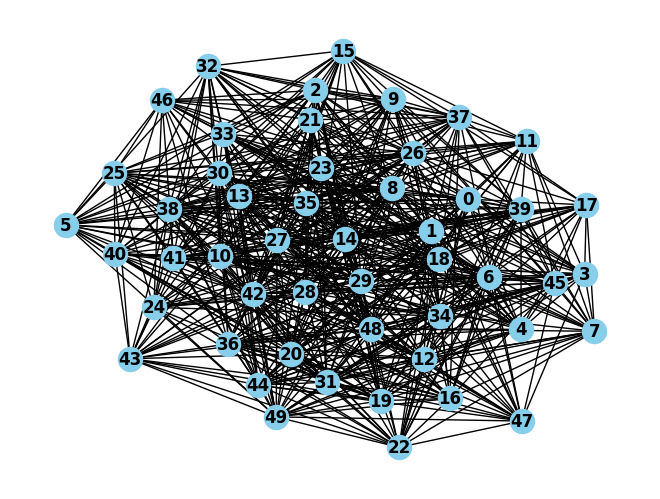

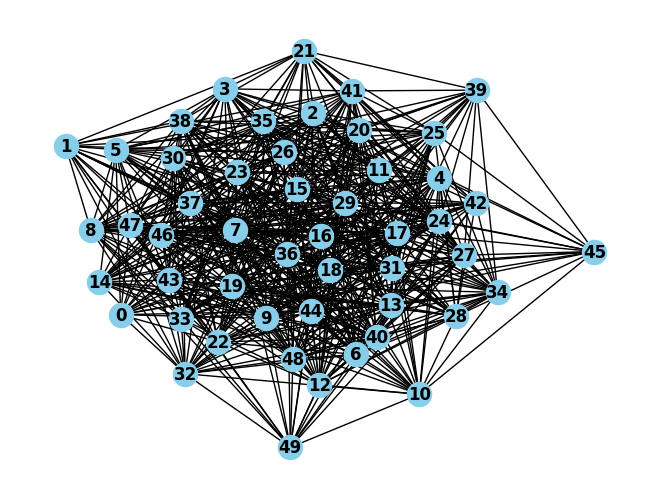

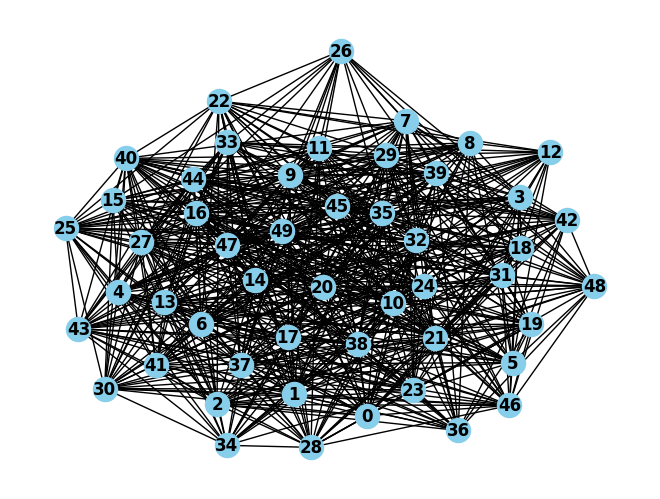

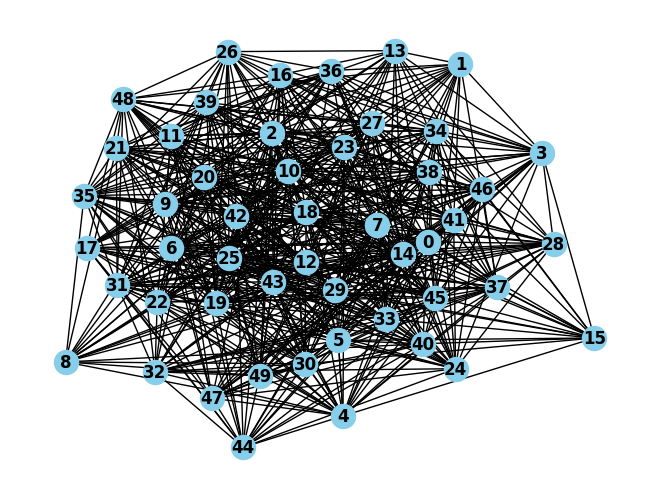

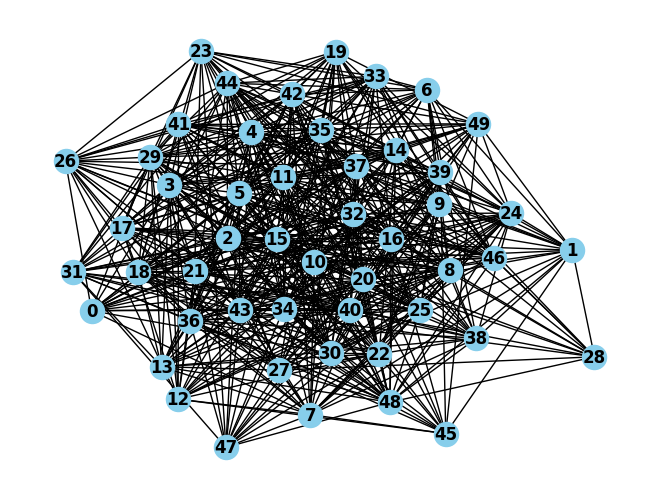

Streaming output truncated to the last 5000 lines.
          28,
          29,
          30,
          31,
          32,
          33,
          34,
          37,
          39,
          40,
          41,
          43,
          44,
          49],
     39: [0,
          1,
          4,
          6,
          7,
          8,
          9,
          10,
          11,
          12,
          13,
          14,
          15,
          16,
          18,
          19,
          20,
          22,
          24,
          26,
          28,
          29,
          38,
          41,
          45,
          46],
     40: [2,
          3,
          9,
          10,
          11,
          13,
          17,
          19,
          20,
          25,
          29,
          31,
          32,
          38,
          41,
          43,
          46,
          47,
          48],
     41: [1,
          2,
          3,
          6,
          12,
          13,
          16,
          17,
          21,
        

In [ ]:
np.random.seed(42)
dataset = create_dataset_graph()
pprint(dataset)

We can now show the results of our three methods: brute-force, local and cloud.

### Brute-force Evaluation

In [ ]:
# TODO: Evaluation Brute-force Method
def brute_force_evaluate(graphs_dict):
   vertex_cover_results = {}
   for graph_id , graph_dict in graphs_dict.items():
     G = nx.Graph(graph_dict)
     vertex_cover_results[graph_id] = brute_force_vertex_cover(G)
   return vertex_cover_results


In [ ]:
dataset_brute_force = brute_force_evaluate(dataset)
print("Brute-Force Vertex Cover Results:")
for graph_id, vertex_cover in dataset_brute_force.items():
    print(f"Graph {graph_id}: {vertex_cover}")

The Brute force method was unable to run properly.  
While it works and can compute a solution especially for shorter graphs, as shown using the example graph, it's unable to handle properly a vertex cover problem of 50 nodes with multiple interconnections.  
After 7 hours of server computation, the kernel was shut down.  
This is expected, as the bruteforce method is highly unoptimized, especially when dealing with an NP problem

### Cloud Evaluation

In [ ]:
def cloud_evaluate(graphs_dict):
  vertex_cover_results = {}
  for graph_id , graph_dict in graphs_dict.items():
    G = nx.Graph(graph_dict)
    response = solve_vertex_cover_nonibm(min_vertex_cover_qubo(G))
    vertex_cover_results[graph_id] = extract_vertex(response,G)
  return vertex_cover_results


In [ ]:
cloud_cover_results = cloud_evaluate(dataset)
print("Cloud Vertex Cover Results:")
for graph_id, vertex_cover in cloud_cover_results.items():
    print(f"Graph: {graph_id}: {vertex_cover}")


Cloud Vertex Cover Results:
Graph: 1: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 18, 19, 22, 23, 24, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
Graph: 2: [1, 2, 3, 5, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 49]
Graph: 3: [0, 1, 2, 3, 4, 6, 7, 9, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49]
Graph: 4: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49]
Graph: 5: [1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49]
Graph: 6: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 18, 19, 22, 23, 25, 26, 27, 28, 29

The Cloud optimized computation was successfull.  
It operated as expected, by delivering correct solutions at high computational speed.  
Specifically, the run took a total of 15 minutes for the whole dataset, demostrating that the problem was quickly handled by the cloud quantum computer

### Local Evaluation

In [ ]:
# Define the QAOA cost function and the quantum circuit
def qaoa_evaluate(graphs_dict):
        wires=50
        vertex_cover_results = {}


        # Define the quantum device
        device = qml.device("qiskit.aer", wires=wires, shots=1000)

        # Define the cost Hamiltonian
        def cost_h():
            # Hamiltonian setup for vertex cover (customize as needed)
            return qml.Hermitian(np.eye(wires), wires=range(wires))

        @qml.qnode(device)
        def circuit(params):
            for i in range(wires):
                qml.Hadamard(wires=i)
            for i in range(len(params[0])):
                qml.RZ(params[0][i], wires=i)
                qml.RX(params[1][i], wires=i)

        # Define the SPSA-optimized circuit
        @qml.qnode(device)
        def spsa_optimized_circuit(gamma, alpha):
            circuit([gamma, alpha])
            return qml.probs(wires=range(wires))

        # Optimized parameters (placeholders, replace with actual values)
        optimized_params = [np.random.uniform(0, np.pi, wires), np.random.uniform(0, np.pi, wires)]

        # Run the circuit
        probs = spsa_optimized_circuit(optimized_params[0], optimized_params[1])

        # Get the binary solution
        solution = np.argmax(probs)
        solution_binary = np.binary_repr(solution, width=wires)

        # Extract vertex cover
        vertex_cover = [idx for idx, bit in enumerate(solution_binary) if bit == '1']

        # Store the result for this graph
        vertex_cover_results[graph_id] = vertex_cover
        print(f"Graph {graph_id}: Vertex Cover = {vertex_cover}")

        return vertex_cover_results




In [ ]:
local_dataset_qaoa_results = qaoa_evaluate(dataset)
for graph_id , vertex_cover in local_dataset_qaoa_results.item():
  print(f"Graph {graph_id}: {vertex_cover}")

ValueError: Backend 'aer_simulator' supports maximum 29 wires

As shown by the error above, the local optimization is unfortunately impossible to compute.  
The number of qbits needed to compute such a large graph is too high for any local machine offered by the library, as well as the machines derived from qiskit.
Despite this, the optimization process has been proven successfull by the cloud implementation, which makes the local simulation unnecessary.